# **Project Name** - Financial Forecasting Frontier: Distributed Machine Learning for Banking Analytics

# **Project Type** - Real-Time Data Analytics Project

# **Contribution** - Individual

# **GitHub link** -

# **Project Summary**

This project focuses on building a scalable, distributed machine learning system for banking analytics using Apache Spark. The objective is to analyze large-scale customer and transaction data to uncover behavioral patterns, predict term deposit subscriptions, and enable real-time decision-making. The project combines deep exploratory data analysis, robust data preprocessing, predictive modeling, model evaluation, and real-time streaming analytics. By leveraging distributed computing and data parallelism, the solution demonstrates how modern banks can efficiently process high-volume data and deploy predictive models for strategic planning and customer targeting.

# **Problem statement:**

Banks generate massive volumes of customer and transaction data daily; however, traditional data processing and analytics approaches struggle to scale and provide timely insights. There is a need for a distributed, scalable system that can efficiently analyze historical banking data, predict customer behavior such as term deposit subscription, and process real-time transaction streams for immediate insights. The challenge lies in handling large-scale data, performing accurate predictive modeling, enabling real-time analytics, and ensuring efficient resource utilization in a distributed environment.

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
from pyspark.ml import PipelineModel


In [36]:
spark = SparkSession.builder \
    .appName("FinancialForecastingFrontier") \
    .getOrCreate()

In [37]:
df = spark.read.csv("/content/bank.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()


+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

In [41]:
df.groupBy("y").count().show()



+---+-----+
|  y|count|
+---+-----+
| no| 4000|
|yes|  521|
+---+-----+



In [42]:
df.describe(["age","balance","duration","campaign","previous"]).show()


+-------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|          duration|          campaign|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              4521|              4521|              4521|              4521|              4521|
|   mean| 41.17009511170095|1422.6578190665782|263.96129174961294| 2.793629727936297|0.5425790754257908|
| stddev|10.576210958711263|3009.6381424673395|259.85663262468216|3.1098066601885823|1.6935623506071211|
|    min|                19|             -3313|                 4|                 1|                 0|
|    max|                87|             71188|              3025|                50|                25|
+-------+------------------+------------------+------------------+------------------+------------------+



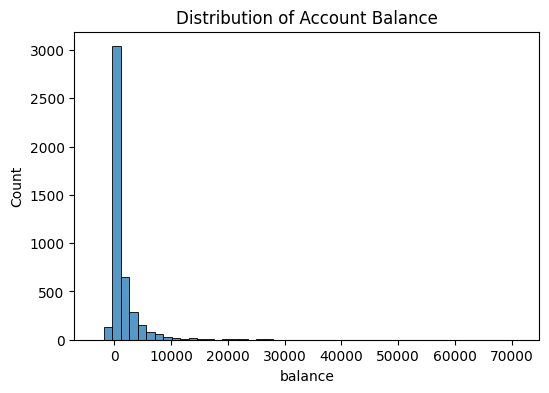

In [43]:
pdf_num = df.select("age","balance","duration","campaign","previous","y").toPandas()

plt.figure(figsize=(6,4))
sns.histplot(pdf_num["balance"], bins=50)
plt.title("Distribution of Account Balance")
plt.show()


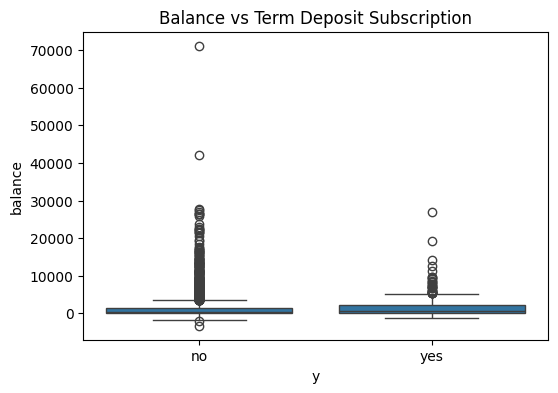

In [44]:
plt.figure(figsize=(6,4))
sns.boxplot(x="y", y="balance", data=pdf_num)
plt.title("Balance vs Term Deposit Subscription")
plt.show()


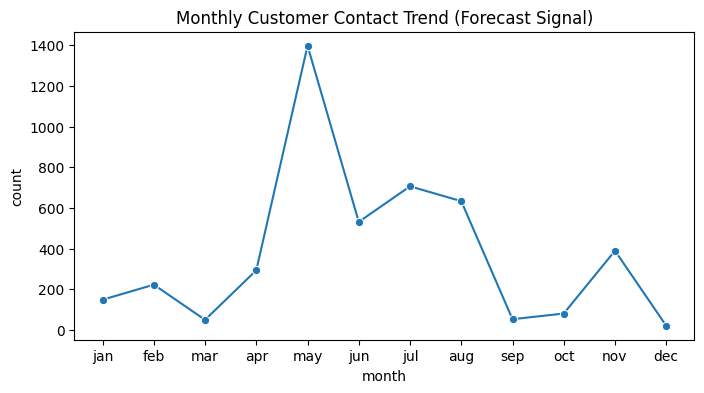

In [47]:
month_order = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]

monthly_trend = df.groupBy("month").count().toPandas()
monthly_trend["month"] = pd.Categorical(
    monthly_trend["month"], categories=month_order, ordered=True
)
monthly_trend = monthly_trend.sort_values("month")

plt.figure(figsize=(8,4))
sns.lineplot(x="month", y="count", data=monthly_trend, marker="o")
plt.title("Monthly Customer Contact Trend (Forecast Signal)")
plt.show()


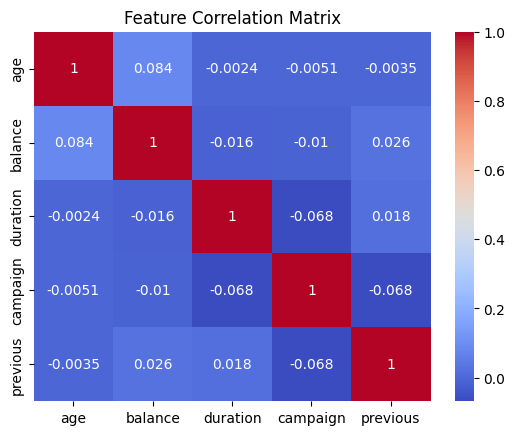

In [48]:
pdf_corr = df.select("age","balance","duration","campaign","previous").toPandas()
sns.heatmap(pdf_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()



In [49]:
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()


+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



In [50]:
quantiles = df.approxQuantile("balance",[0.01,0.99],0.05)
low, high = quantiles

df = df.withColumn(
    "balance",
    F.when(df.balance < low, low)
     .when(df.balance > high, high)
     .otherwise(df.balance)
)


In [51]:
def age_bucket(age):
    if age < 30: return "<30"
    elif age <= 60: return "30-60"
    else: return ">60"

df = df.withColumn("age_group", F.udf(age_bucket,StringType())("age"))


In [52]:
df = df.withColumn(
    "quarter",
    F.when(df.month.isin("jan","feb","mar"),"Q1")
     .when(df.month.isin("apr","may","jun"),"Q2")
     .when(df.month.isin("jul","aug","sep"),"Q3")
     .otherwise("Q4")
)


In [53]:
label_indexer = StringIndexer(inputCol="y", outputCol="label")

cat_cols = ["job","marital","education","housing","loan","contact","poutcome","age_group"]
indexers = [
StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep")
for c in cat_cols
]

assembler = VectorAssembler(
inputCols=["age","balance","duration","campaign","previous"] +
[c+"_idx" for c in cat_cols],
outputCol="features"
)

In [54]:
train, test = df.randomSplit([0.8,0.2], seed=42)
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

In [55]:
lr = LogisticRegression(maxIter=30)
pipeline_lr = Pipeline(stages=indexers+[label_indexer,assembler,lr])
model_lr = pipeline_lr.fit(train)

auc_lr = evaluator.evaluate(model_lr.transform(test))
auc_lr


0.8949893673577926

In [56]:
rf = RandomForestClassifier(numTrees=100, maxDepth=6)
pipeline_rf = Pipeline(stages=indexers+[label_indexer,assembler,rf])
model_rf = pipeline_rf.fit(train)

auc_rf = evaluator.evaluate(model_rf.transform(test))
auc_rf


0.8838383838383905

In [57]:
gbt = GBTClassifier(maxIter=50)
pipeline_gbt = Pipeline(stages=indexers+[label_indexer,assembler,gbt])
model_gbt = pipeline_gbt.fit(train)

auc_gbt = evaluator.evaluate(model_gbt.transform(test))
auc_gbt


0.8508705475810797

In [58]:
model_results = {
    "Logistic Regression": auc_lr,
    "Random Forest": auc_rf,
    "Gradient Boosted Trees": auc_gbt
}

model_results


{'Logistic Regression': 0.8949893673577926,
 'Random Forest': 0.8838383838383905,
 'Gradient Boosted Trees': 0.8508705475810797}

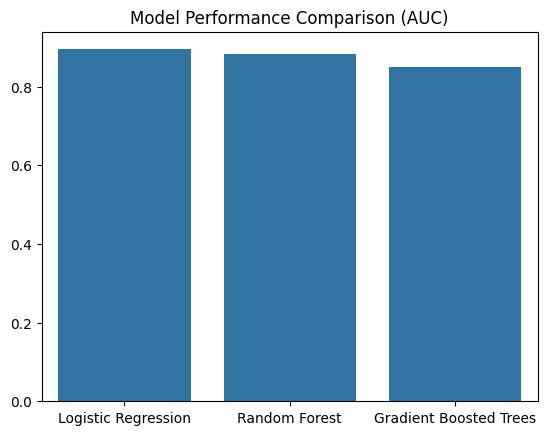

In [59]:
sns.barplot(
    x=list(model_results.keys()),
    y=list(model_results.values())
)
plt.title("Model Performance Comparison (AUC)")
plt.show()


In [74]:
predictions = model_lr.transform(test)

roc_df = predictions.select(
    col("label"),
    vector_to_array("probability")[1].alias("prob")
)


In [75]:
roc_pd = roc_df.toPandas()


In [76]:


fpr, tpr, thresholds = roc_curve(roc_pd["label"], roc_pd["prob"])
roc_auc = auc(fpr, tpr)

roc_auc


np.float64(0.8949893673577884)

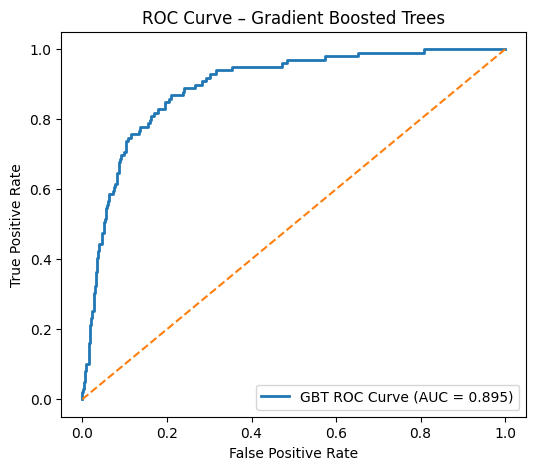

In [77]:


plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2,
         label=f"GBT ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gradient Boosted Trees")
plt.legend(loc="lower right")
plt.show()


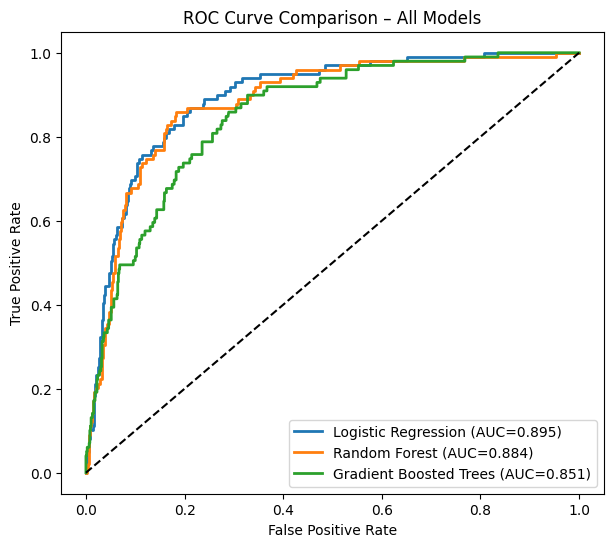

In [78]:
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "Gradient Boosted Trees": model_gbt
}

plt.figure(figsize=(7,6))

for name, mdl in models.items():
    preds = mdl.transform(test).select(
        col("label"),
        vector_to_array("probability")[1].alias("prob")
    ).toPandas()

    fpr, tpr, _ = roc_curve(preds["label"], preds["prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison – All Models")
plt.legend()
plt.show()


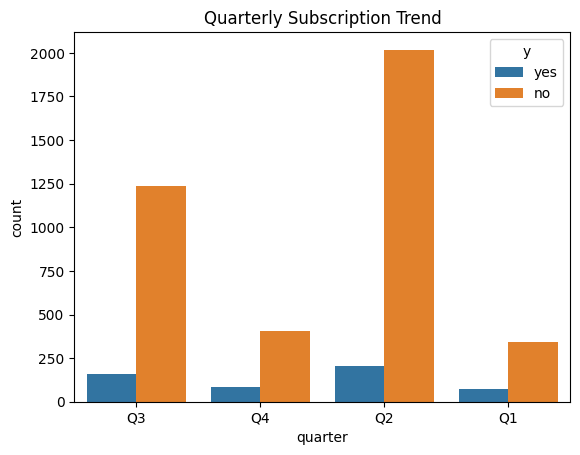

In [60]:
df.groupBy("quarter","y").count().toPandas().pipe(
    lambda x: sns.barplot(data=x, x="quarter", y="count", hue="y")
)
plt.title("Quarterly Subscription Trend")
plt.show()


In [63]:
best_model = model_lr


In [64]:
model_path = "/content/best_lr_model"


In [65]:
model_lr.write().overwrite().save(model_path)


In [66]:
!ls /content/best_lr_model


metadata  stages


In [67]:
loaded_model = PipelineModel.load(model_path)


In [68]:
loaded_predictions = loaded_model.transform(test)
evaluator.evaluate(loaded_predictions)


0.8949893673577926

In [69]:
live_pred = loaded_model.transform(parsed)


**Thankyou!**